In [1]:
import torch
import torchtext
from torchtext.datasets import text_classification

import pandas as pd
from nltk.tokenize import word_tokenize

import os

NGRAMS = 1
BATCH_SIZE = 16
PRETRAINED = True
WORD2VEC_MODEL = True
FREEZE = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Load Data

In [2]:
def preprocess_text(text):
    return word_tokenize(str(text.replace('\n', ' ').replace('\t', ' ').encode().strip()))

df_dataset = pd.read_json('dataset_full.json')

df = df_dataset[['type', 'text']]

df['text'] = df['text'].apply(preprocess_text)

ltoi = {l: i+1 for i,l in enumerate(df['type'].unique())}
print(ltoi)
df['type'] = df['type'].apply(lambda x: ltoi[x])

{'ongoing-event': 1, 'meme': 2, 'news': 3, 'commemorative': 4}


### Word2Vec Embedding

In [3]:
import gensim
from gensim.models import Word2Vec

if PRETRAINED and WORD2VEC_MODEL:
    model_w2v = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
    weights = torch.FloatTensor(model_w2v.vectors)
elif not PRETRAINED and WORD2VEC_MODEL:
    print('Manual Train')
    tweets = df['text'].to_list()
    model = Word2Vec(tweets,
                        min_count=2,
                        window=5,
                        size=300,
                        sample=6e-5,
                        alpha=0.03,
                        min_alpha=0.0007,
                        negative=20)
    # do training here
    model.train(tweets, total_examples=len(tweets), epochs=20)
    # model_w2v.init_sims(replace=True)
    word_vectors = model.wv
    word_vectors.save('vectors.kv')

    model_w2v = gensim.models.KeyedVectors.load('vectors.kv')
    weights = torch.FloatTensor(model_w2v.vectors)


### Dividing the data set in to training/test set

In [4]:
from sklearn.model_selection import train_test_split
from torchtext.datasets.text_classification import _create_data_from_iterator, _csv_iterator, build_vocab_from_iterator

import itertools

train_df, test_df = train_test_split(df, test_size=0.2, random_state=1)

if not os.path.exists('./.cache'):
    os.mkdir('./.cache')

train_df.to_csv('./.cache/train.csv', index=False, header=False)
test_df.to_csv('./.cache/test.csv', index=False, header=False)

include_unknown = False

from torchtext.datasets.text_classification import TextClassificationDataset
import collections
from torchtext.vocab import Vocab

vocab = build_vocab_from_iterator(_csv_iterator('./.cache/train.csv', NGRAMS))

train_data, train_labels = _create_data_from_iterator(vocab, _csv_iterator('./.cache/train.csv', NGRAMS, yield_cls=True), include_unk=include_unknown)
test_data, test_labels = _create_data_from_iterator(vocab, _csv_iterator('./.cache/test.csv', NGRAMS, yield_cls=True), include_unk=include_unknown)

train_dataset = TextClassificationDataset(vocab=vocab, data=train_data, labels=train_labels)
test_dataset = TextClassificationDataset(vocab=vocab, data=test_data, labels=test_labels)

270642lines [00:11, 24106.29lines/s]
270642lines [00:21, 12681.65lines/s]
67661lines [00:06, 10925.12lines/s]


In [5]:
if WORD2VEC_MODEL:
    word2index = {token: token_index for token_index, token in enumerate(model_w2v.index2word)}
    train_dataset._vocab.set_vectors(word2index, weights.to(device), model_w2v.vector_size)
    test_dataset._vocab.set_vectors(word2index, weights.to(device), model_w2v.vector_size)

### The Model

In [6]:
import torch.nn as nn
import torch.nn.functional as F 

class CNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class, windows_size, num_filter, model=WORD2VEC_MODEL, freeze=FREEZE):
        super().__init__()

        self.model = WORD2VEC_MODEL
        self.freeze = FREEZE

        if self.model:
            self.embedding = nn.Embedding.from_pretrained(weights)
        else:
            self.embedding = nn.Embedding(vocab, embed_dim, sparse=True)
            self.init_weights()
        
        self.embedding.weight.requires_grad = self.freeze    

        self.convs = nn.ModuleList([nn.Conv2d(1, 
                                            num_filter, 
                                            [window, embed_dim]) 
                                            for window in windows_size])

        self.fc = nn.Linear(num_filter * len(windows_size), num_class)

    def init_weights(self):
        init_range = 0.5
        self.embedding.weight.data.uniform_(-init_range, init_range)
        self.fc.weight.data.uniform_(-init_range, init_range)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        if self.model:
            embedded = self.embedding(text)
        else:
            embedded = self.embedding(text, offsets)

        embedded = torch.unsqueeze(embedded, 1)

        x = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        
        x = [F.max_pool1d(i, i.size(2)) for i in x]
        
        x = torch.cat(x, 1)
        
        x = x.view(x.size(0), -1)

        return self.fc(x)
        
        # return F.softmax(logits, dim=1)

### Initialize Parameters

In [7]:
VOCAB_SIZE = len(train_dataset.get_vocab())
EMBED_DIM = 32

if WORD2VEC_MODEL:
    EMBED_DIM = weights.shape[1]

NUM_CLASS = len(train_dataset.get_labels())

cnn_model = CNNModel(VOCAB_SIZE, EMBED_DIM, NUM_CLASS, [1,2,3], 5, WORD2VEC_MODEL).to(device)

### Padding the text to have the same length 

In [8]:
def padding_tensor(sequences):
    num = len(sequences)
    max_len = max([s.size(0) for s in sequences])
    out_dim = (num, max_len)
    out_tensor = sequences[0].data.new(*out_dim).fill_(0)

    for i, tensor in enumerate(sequences):
        length = tensor.size(0)
        out_tensor[i, :length] = tensor
    
    return out_tensor

In [9]:
def generate_batch(batch, model=WORD2VEC_MODEL):
    labels = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    if model:
        text = padding_tensor(text)
    else:
        text = torch.cat(text)

    return text, offsets, labels

### Train/Test function

In [10]:
from torch.utils.data import DataLoader

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss().to(device)

def cnn_train_func(sub_train_):
    train_loss = 0
    train_acc = 0

    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, 
                        shuffle=True, collate_fn=generate_batch)
    
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        
        output = cnn_model(text, offsets)
        
        loss = criterion(output, cls)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        train_acc += (output.argmax(1) == cls).sum().item()

    # scheduler.step()

    return train_loss/len(sub_train_), train_acc/len(sub_train_)

def cnn_test(data_):
    test_loss = 0
    acc = 0

    y_true, y_pred = [], []

    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch) 

    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = cnn_model(text, offsets)
            loss = criterion(output, cls)
            test_loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()

            y_pred += output.argmax(1)
            y_true += cls

    return test_loss/len(data_), acc/len(data_), y_true, y_pred

### Training

In [11]:
import time
from torch.utils.data.dataset import random_split

min_valid_loss = float('inf')

loss_file_name = 'loss_cnn.csv'
f = open(loss_file_name, 'w+')
f.write('epoch,loss')
f.write('\n')

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss().to(device)

train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = random_split(train_dataset, [train_len, len(train_dataset) - train_len], generator=torch.Generator().manual_seed(1))

N_EPOCHS = 5

for epoch in range(N_EPOCHS):
    start_time = time.time()
    cnn_model.train()
    train_loss, train_acc = cnn_train_func(sub_train_)
    cnn_model.eval()
    valid_loss, valid_acc, _, _  = cnn_test(sub_valid_)

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), ' | time in %d minutes, %d seconds' %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

    f.write(str(epoch+1) + ',' + str(valid_loss))
    f.write('\n')

f.close()

KeyboardInterrupt: 

### Testing

Checking the results of test dataset...
	Loss: 0.0060(test)	|	Acc: 96.9%(test)
               precision    recall  f1-score   support

ongoing-event       0.97      0.99      0.98     35673
         meme       0.97      0.96      0.96     14822
         news       0.97      0.95      0.96     15084
commemorative       0.97      0.92      0.95      2082

     accuracy                           0.97     67661
    macro avg       0.97      0.95      0.96     67661
 weighted avg       0.97      0.97      0.97     67661

Index(['epoch', 'loss'], dtype='object')


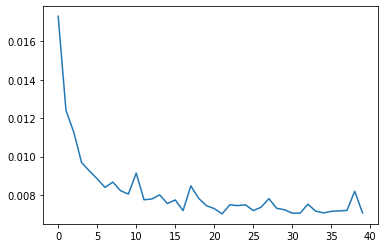

In [24]:
print('Checking the results of test dataset...')
test_loss, test_acc, y_true, y_pred = cnn_test(test_dataset)
print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=ltoi.keys()))

import matplotlib.pyplot as plt 

loss_df = pd.read_csv(loss_file_name)
print(loss_df.columns)
plt_500_padding_30_epochs = loss_df['loss'].plot()
fig = plt_500_padding_30_epochs.get_figure()
plt.show()